In [28]:
# Imports & Setup
import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [29]:
# Load Dataset
ratings = pd.read_csv("/kaggle/input/movielens-dataset-100k-ratings/ml-latest-small/ratings.csv")
movies = pd.read_csv("/kaggle/input/movielens-dataset-100k-ratings/ml-latest-small/movies.csv")
tags = pd.read_csv("/kaggle/input/movielens-dataset-100k-ratings/ml-latest-small/tags.csv")
links = pd.read_csv("/kaggle/input/movielens-dataset-100k-ratings/ml-latest-small/links.csv")

print("Ratings:", ratings.shape)
print("Movies:", movies.shape)
print("Tags:", tags.shape)
print("Links:", links.shape)

Ratings: (100836, 4)
Movies: (9742, 3)
Tags: (3683, 4)
Links: (9742, 3)


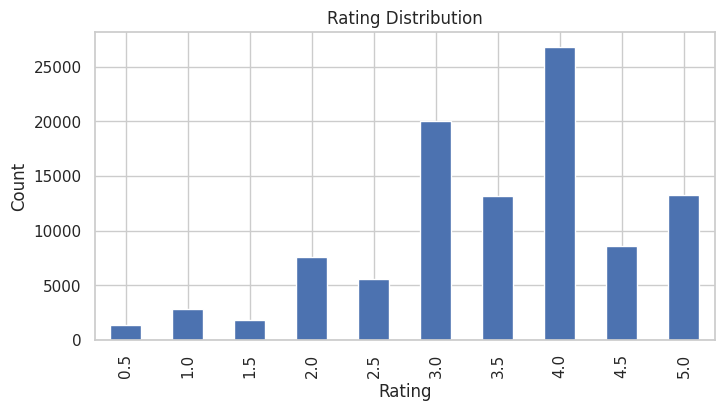

In [30]:
#Exploratory Data Analysis
ratings['rating'].value_counts().sort_index().plot(kind='bar', figsize=(8,4))
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [101]:
# Train / Test Split (Timestamp-Based)

ratings = ratings.sort_values("timestamp")

# Take last 5 interactions per user as test
test = ratings.groupby("userId").tail(5)

# Remaining interactions are train
train = ratings.drop(test.index)

print("Train size:", train.shape)
print("Test size:", test.shape)

Train size: (97786, 4)
Test size: (3050, 4)


In [102]:
# Create User-Item Matrix (Train Only)
user_item_train = train.pivot_table(
    index="userId",
    columns="movieId",
    values="rating"
).fillna(0)

user_item_train.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193567,193571,193573,193579,193581,193583,193585,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
# User-Based Collaborative Filtering (Similarity)
user_similarity = cosine_similarity(user_item_train)
user_similarity_df = pd.DataFrame(
    user_similarity,
    index=user_item_train.index,
    columns=user_item_train.index
)



In [104]:
# Recommend Movies for a User (User-Based CF)
def recommend_user_based(user_id, top_n=10):
    if user_id not in user_item_train.index:
        return pd.Series(dtype=float)
    
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:6]
    
    weighted_ratings = np.dot(
        similar_users.values,
        user_item_train.loc[similar_users.index]
    ) / similar_users.sum()
    
    scores = pd.Series(weighted_ratings, index=user_item_train.columns)
    
    already_rated = user_item_train.loc[user_id]
    scores = scores[already_rated == 0]
    
    return scores.sort_values(ascending=False).head(top_n)

In [105]:
recommend_user_based(user_id=1)

movieId
1200    4.610275
924     4.192392
1610    4.011178
589     4.003482
1036    4.000000
541     3.999194
858     3.967645
1374    3.791281
2968    3.597638
1221    3.563841
dtype: float64

In [106]:
# Precision@K Evaluation (User-Based)
def precision_at_k(model_func, user_id, k=10):
    recommended = model_func(user_id, k).index
    relevant = ratings[(ratings.userId == user_id) & (ratings.rating >= 4)].movieId
    
    if len(recommended) == 0:
        return 0
    
    return len(set(recommended) & set(relevant)) / k

In [107]:
precision_scores = [
    precision_at_k(recommend_user_based, user, k=10)
    for user in ratings.userId.unique()[:50]
]

np.mean(precision_scores)

np.float64(0.03)

In [108]:
#  Item-Based Collaborative Filtering (Matrix Factorization)
svd = TruncatedSVD(n_components=50, random_state=77)
latent_user_matrix = svd.fit_transform(user_item_train)

item_factors = svd.components_.T
item_similarity = cosine_similarity(item_factors)

item_similarity_df = pd.DataFrame(
    item_similarity,
    index=user_item_train.columns,
    columns=user_item_train.columns
)

In [110]:
# Item-Based Recommendations
def recommend_item_based(user_id, top_n=10):
    if user_id not in user_item_train.index:
        return pd.Series(dtype=float)
    
    user_ratings = user_item_train.loc[user_id]
    scores = item_similarity_df.dot(user_ratings)
    
    scores = scores[user_ratings == 0]
    return scores.sort_values(ascending=False).head(top_n)

In [111]:
recommend_item_based(user_id=1)

movieId
2818     143.373681
1422     133.881433
2085     130.395789
61697    128.141900
2535     125.558873
2566     124.300877
2080     124.287356
1826     123.301112
1582     121.590864
2087     121.580916
dtype: float64

In [112]:
# Precision@K for Item-Based CF
precision_item = [
    precision_at_k(recommend_item_based, user, k=10)
    for user in ratings.userId.unique()[:50]
]

np.mean(precision_item)

np.float64(0.03)

In [113]:
# Content-Based Filtering (Genres)
# Handle missing genres safely
#Genre Encoding (Safe & Idempotent)

def normalize_genres(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        return x.split('|') if x != '' else []
    return []

movies['genres'] = movies['genres'].apply(normalize_genres)

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(movies['genres'])

genre_df = pd.DataFrame(
    genre_matrix,
    columns=mlb.classes_,
    index=movies['movieId']
)

genre_df.head()

""
movieId
1
2
3
4
5


In [114]:
# Build User Profile & Recommend (Content-Based)
def recommend_content_based(user_id, top_n=10):
    user_train = train[train.userId == user_id]
    
    if user_train.empty:
        return pd.Series(dtype=float)
    
    merged = user_train.merge(
        genre_df, left_on="movieId", right_index=True
    )
    
    user_profile = merged[mlb.classes_].T.dot(merged["rating"])
    
    scores = genre_df.dot(user_profile)
    scores = scores[~scores.index.isin(user_train.movieId)]
    
    return scores.sort_values(ascending=False).head(top_n)

In [115]:
recommend_content_based(user_id=1)


movieId
193609    0.0
2         0.0
4         0.0
5         0.0
7         0.0
8         0.0
9         0.0
10        0.0
11        0.0
12        0.0
dtype: float64

In [116]:
# Precision@K for Content-Based Model
def precision_at_k(model_func, user_id, k=10):
    relevant = test[
        (test.userId == user_id) & (test.rating >= 4)
    ].movieId
    
    if relevant.empty:
        return np.nan
    
    recommended = model_func(user_id, k).index
    
    return len(set(recommended) & set(relevant)) / k

In [117]:
users = test.userId.unique()[:100]

precision_user = np.nanmean([
    precision_at_k(recommend_user_based, u, 10) for u in users
])

precision_item = np.nanmean([
    precision_at_k(recommend_item_based, u, 10) for u in users
])

precision_content = np.nanmean([
    precision_at_k(recommend_content_based, u, 10) for u in users
])

precision_user, precision_item, precision_content

(np.float64(0.031111111111111114),
 np.float64(0.02888888888888889),
 np.float64(0.005555555555555556))

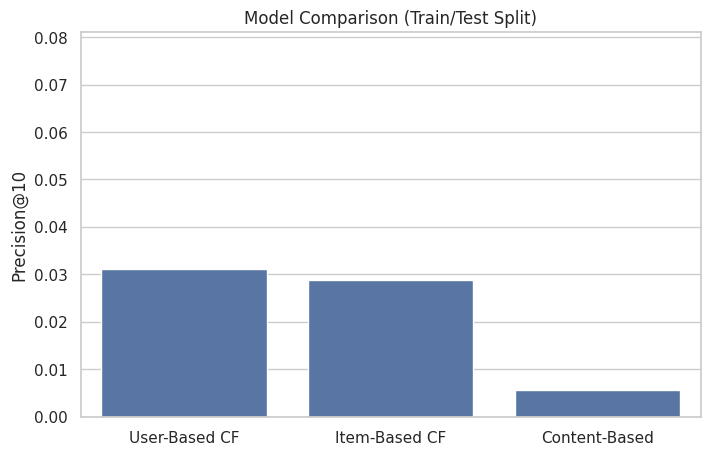

In [119]:
models = [
    "User-Based CF",
    "Item-Based CF",
    "Content-Based"
]

scores = [
    precision_user,
    precision_item,
    precision_content
]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=scores)
plt.ylim(0, max(scores) + 0.05)
plt.ylabel("Precision@10")
plt.title("Model Comparison (Train/Test Split)")
plt.show()

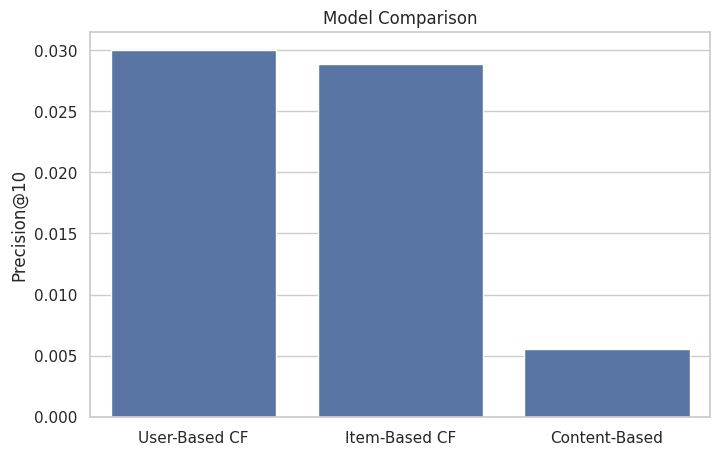

In [118]:
# Model Performance Comparison (Charts)
models = ['User-Based CF', 'Item-Based CF', 'Content-Based']
scores = [
    np.mean(precision_scores),
    np.mean(precision_item),
    np.mean(precision_content)
]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=scores)
plt.ylabel("Precision@10")
plt.title("Model Comparison")
plt.show()


In [121]:
#  Test & Visualize Recommendations from All Models 

def map_movie_titles(movie_ids, movies_df):
    return movies_df.set_index('movieId').loc[movie_ids]['title'].values


TEST_USER_ID = 1
TOP_N = 10

# User-Based CF
user_cf_recs = recommend_user_based(TEST_USER_ID, TOP_N)
user_cf_titles = map_movie_titles(user_cf_recs.index, movies)

# Item-Based CF
item_cf_recs = recommend_item_based(TEST_USER_ID, TOP_N)
item_cf_titles = map_movie_titles(item_cf_recs.index, movies)

# Content-Based
content_recs = recommend_content_based(TEST_USER_ID, TOP_N)
content_titles = map_movie_titles(content_recs.index, movies)

# Display Results
results_df = pd.DataFrame({
    "User-Based CF": user_cf_titles,
    "Item-Based CF": item_cf_titles,
    "Content-Based": content_titles
})

results_df

,User-Based CF,Item-Based CF,Content-Based
0,Aliens (1986),Iron Eagle IV (1995),Andrew Dice Clay: Dice Rules (1991)
1,2001: A Space Odyssey (1968),Murder at 1600 (1997),Jumanji (1995)
2,"Hunt for Red October, The (1990)",101 Dalmatians (One Hundred and One Dalmatians...,Waiting to Exhale (1995)
3,Terminator 2: Judgment Day (1991),Righteous Kill (2008),Father of the Bride Part II (1995)
4,Die Hard (1988),Earthquake (1974),Sabrina (1995)
5,Blade Runner (1982),Doug's 1st Movie (1999),Tom and Huck (1995)
6,"Godfather, The (1972)",Lady and the Tramp (1955),Sudden Death (1995)
7,Star Trek II: The Wrath of Khan (1982),Barney's Great Adventure (1998),GoldenEye (1995)
8,Time Bandits (1981),Wild America (1997),"American President, The (1995)"
9,"Godfather: Part II, The (1974)",Peter Pan (1953),Dracula: Dead and Loving It (1995)


In [47]:
# Render Results in an HTML Page
from IPython.display import display, HTML

def render_recommendation_table(title, rec_series, movies_df):
    df = rec_series.reset_index()
    df.columns = ['movieId', 'score']
    
    df = df.merge(movies_df[['movieId', 'title']], on='movieId')
    df['Rank'] = range(1, len(df) + 1)
    df = df[['Rank', 'title', 'score']]
    
    html = f"""
    <h3 style="margin-top:30px;">🎬 {title}</h3>
    <table style="
        border-collapse: collapse;
        width: 100%;
        font-family: Arial, sans-serif;
        font-size: 14px;">
        <thead>
            <tr style="background-color:#222;color:white;">
                <th style="padding:8px;">Rank</th>
                <th style="padding:8px;">Movie</th>
                <th style="padding:8px;">Score</th>
            </tr>
        </thead>
        <tbody>
    """
    
    for _, row in df.iterrows():
        html += f"""
        <tr>
            <td style="padding:8px;text-align:center;">{row['Rank']}</td>
            <td style="padding:8px;">{row['title']}</td>
            <td style="padding:8px;">{row['score']:.3f}</td>
        </tr>
        """
    
    html += "</tbody></table>"
    display(HTML(html))


# ===== Display Recommendations =====

TEST_USER_ID = 1
TOP_N = 10

render_recommendation_table(
    "User-Based Collaborative Filtering",
    recommend_user_based(TEST_USER_ID, TOP_N),
    movies
)

render_recommendation_table(
    "Item-Based Collaborative Filtering (Matrix Factorization)",
    recommend_item_based(TEST_USER_ID, TOP_N),
    movies
)

render_recommendation_table(
    "Content-Based Filtering",
    recommend_content_based(TEST_USER_ID, TOP_N),
    movies
)

Rank,Movie,Score
1,Aliens (1986),4.801
2,"Hunt for Red October, The (1990)",4.299
3,Blade Runner (1982),4.005
4,Terminator 2: Judgment Day (1991),4.004
5,Die Hard (1988),4.000
6,"Godfather, The (1972)",3.969
7,2001: A Space Odyssey (1968),3.907
8,Star Trek II: The Wrath of Khan (1982),3.890
9,Airplane! (1980),3.474
10,"Godfather: Part II, The (1974)",3.374


Rank,Movie,Score
1,Doug's 1st Movie (1999),152.027
2,Wild America (1997),150.452
3,Barney's Great Adventure (1998),149.068
4,Firewalker (1986),140.119
5,Popeye (1980),137.405
6,101 Dalmatians (One Hundred and One Dalmatians) (1961),137.371
7,Red Sonja (1985),134.673
8,Righteous Kill (2008),129.983
9,Superman IV: The Quest for Peace (1987),129.386
10,Iron Eagle IV (1995),125.624


Rank,Movie,Score
1,Rubber (2010),2018.000
2,Dragonheart 2: A New Beginning (2000),1855.000
3,Aelita: The Queen of Mars (Aelita) (1924),1781.000
4,"Stunt Man, The (1980)",1765.000
5,Osmosis Jones (2001),1724.000
6,Maximum Ride (2016),1716.000
7,Interstate 60 (2002),1710.000
8,Aqua Teen Hunger Force Colon Movie Film for Theaters (2007),1699.000
9,Super Mario Bros. (1993),1679.000
10,"Hunting Party, The (2007)",1653.000
